Imports

In [1]:
from pathlib import Path
import json
import csv
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from PIL import Image

import matplotlib.pyplot as plt


Configuration

In [ ]:
PROCESSED_ROOT = Path("../../data/processed/Stage0")
INDEX_CSV = PROCESSED_ROOT / "index.csv"

VAL_LABELS_JSON = Path("../../data/labels/Stage0/val.json")   # validate on val
TEST_LABELS_JSON = Path("../../data/labels/test.json")  # later only, when frozen

MODEL_PATH = Path("../../models/classifier/Stage0/model.pt")

IMAGE_MODE = "rgb"    # "rgb" or "gray" (must match training)
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_CLASSES = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Load index.csv

In [3]:
def read_index_csv(index_csv_path: Path):
    rows = []
    with open(index_csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            rows.append(r)
    if not rows:
        raise ValueError(f"index.csv empty: {index_csv_path}")
    if "filepath" not in rows[0]:
        raise ValueError("index.csv must have a 'filepath' column")
    return rows

index_rows = read_index_csv(INDEX_CSV)
print("index rows:", len(index_rows))
print("example:", index_rows[0]["filepath"], "split:", index_rows[0].get("split"))


index rows: 75
example: images/train/2026-01-21_10-34-47-193_aug01.png split: train


Load val labels

In [4]:
def load_label_map(label_path: Path):
    if not label_path.exists():
        raise FileNotFoundError(f"Label file not found: {label_path}")
    with open(label_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict):
        # Original format: {filepath: class_id}
        return {k.replace("\\", "/"): int(v) for k, v in data.items()}
    elif isinstance(data, list):
        # Label Studio format: list of tasks
        out = {}
        for item in data:
            filepath = item['file_upload']
            if item['annotations'] and item['annotations'][0]['result']:
                choices = item['annotations'][0]['result'][0]['value']['choices']
                # Assume 0 for no_contraband, 1 otherwise
                class_id = 0 if 'no_contraband' in choices else 1
            else:
                class_id = 0  # default
            out[filepath] = class_id
        return out
    else:
        raise ValueError("Label JSON must be a dict {filepath: class_id} or Label Studio list format")

val_label_map = load_label_map(VAL_LABELS_JSON)
print("Val labels:", len(val_label_map))

# show a few
for i, (k, v) in enumerate(val_label_map.items()):
    print(k, "->", v)
    if i >= 2:
        break

Val labels: 8
989b625c-2026-01-21_10-32-05-130.png -> 1
d6c7383d-2026-01-21_10-32-05-130_orig.png -> 1
a7520945-2026-01-21_10-32-40-301_aug01.png -> 1


Dataset(split-safe)

In [5]:
class ProcessedSplitDataset(Dataset):
    def __init__(self, index_rows, processed_root: Path, split: str, label_map: dict, transform=None):
        self.processed_root = processed_root
        self.split = split
        self.transform = transform
        self.label_map = label_map

        fps = []
        for r in index_rows:
            fp = r["filepath"].replace("\\", "/")
            row_split = (r.get("split") or "").strip().lower()

            if row_split:
                if row_split == split:
                    fps.append(fp)
            else:
                if f"images/{split}/" in fp:
                    fps.append(fp)

        if not fps:
            raise ValueError(f"No samples found for split='{split}'")

        # Use labels, default to 0 if missing
        self.filepaths = []
        self.labels = []
        for fp in fps:
            filename = Path(fp).name
            label = self.label_map.get(filename, 0)  # default to 0
            self.filepaths.append(fp)
            self.labels.append(label)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        rel = self.filepaths[idx]
        img_path = self.processed_root / rel

        img = Image.open(img_path)
        if IMAGE_MODE == "gray":
            img = img.convert("L")
        else:
            img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)

        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, y, rel

Transforms + DataLoader

In [6]:
if IMAGE_MODE == "gray":
    transform = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),  # [1,H,W]
    ])
    in_channels = 1
else:
    transform = T.Compose([
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),  # [3,H,W]
    ])
    in_channels = 3

test_ds = ProcessedSplitDataset(index_rows, PROCESSED_ROOT, "test", val_label_map, transform=transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Val samples:", len(test_ds))
x, y, p = next(iter(test_loader))
print("Batch shape:", x.shape, "| labels:", y[:5].tolist())


Val samples: 5
Batch shape: torch.Size([5, 3, 256, 256]) | labels: [0, 0, 0, 0, 0]


Define the same model architecture + load weights

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2, image_size=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, image_size, image_size)
            out = self.features(dummy)
            flat_dim = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 128), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN(in_channels=in_channels, num_classes=NUM_CLASSES, image_size=IMAGE_SIZE).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

criterion = nn.CrossEntropyLoss()

print("✅ Model loaded from:", MODEL_PATH)


✅ Model loaded from: ../models/classifier/Stage0/model.pt


Run validation (loss, acc, predictions, probs)

In [8]:
all_y = []
all_pred = []
all_prob = []
all_paths = []
loss_sum = 0.0
n_total = 0

with torch.no_grad():
    for imgs, y, paths in test_loader:
        imgs = imgs.to(device)
        y = y.to(device)

        logits = model(imgs)
        loss = criterion(logits, y)

        probs = torch.softmax(logits, dim=1)
        pred = probs.argmax(dim=1)

        loss_sum += loss.item() * imgs.size(0)
        n_total += y.size(0)

        all_y.extend(y.cpu().numpy().tolist())
        all_pred.extend(pred.cpu().numpy().tolist())
        all_prob.extend(probs.max(dim=1).values.cpu().numpy().tolist())
        all_paths.extend(list(paths))

val_loss = loss_sum / max(1, n_total)
val_acc = (np.array(all_pred) == np.array(all_y)).mean()

print(f"Val Loss: {val_loss:.4f}")
print(f"Val Acc : {val_acc:.4f}")


Val Loss: 0.0000
Val Acc : 1.0000


Average confidence: 1.0000
Min confidence: 1.0000
Max confidence: 1.0000
Median confidence: 1.0000


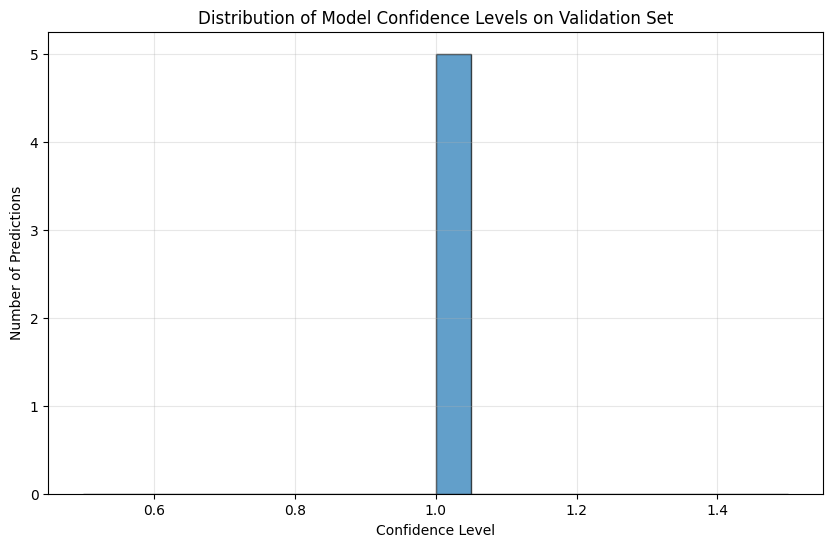

Average confidence for correct predictions: 1.0000
Average confidence for incorrect predictions: nan


/tmp/ipykernel_31660/1458861090.py:25: RuntimeWarning: Mean of empty slice.
  print(f"Average confidence for incorrect predictions: {incorrect_conf.mean():.4f}")
/home/ssy/Desktop/xray-gen-ai_Project/xray-gen-ai/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


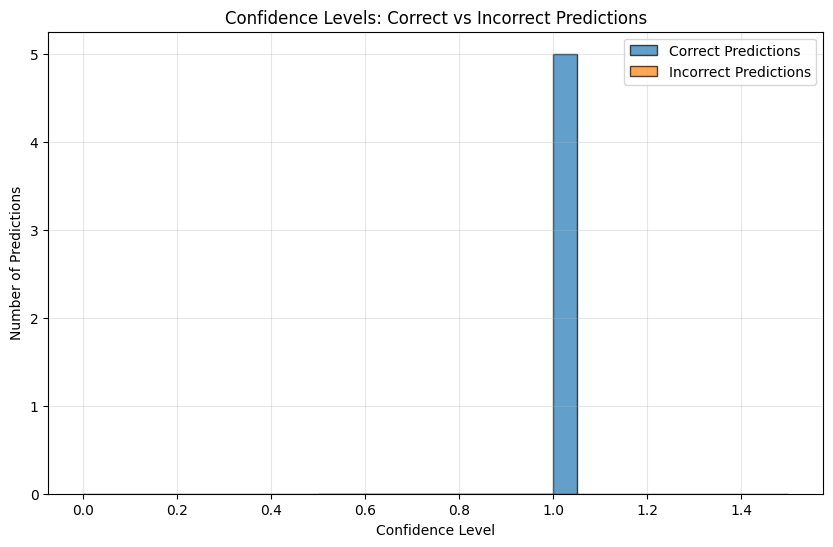

In [9]:
import matplotlib.pyplot as plt

# Analyze confidence levels
confidences = np.array(all_prob)
print(f"Average confidence: {confidences.mean():.4f}")
print(f"Min confidence: {confidences.min():.4f}")
print(f"Max confidence: {confidences.max():.4f}")
print(f"Median confidence: {np.median(confidences):.4f}")

# Plot histogram of confidence levels
plt.figure(figsize=(10, 6))
plt.hist(confidences, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence Level')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Model Confidence Levels on Validation Set')
plt.grid(True, alpha=0.3)
plt.show()

# Show confidence for correct vs incorrect predictions
correct_mask = np.array(all_pred) == np.array(all_y)
correct_conf = confidences[correct_mask]
incorrect_conf = confidences[~correct_mask]

print(f"Average confidence for correct predictions: {correct_conf.mean():.4f}")
print(f"Average confidence for incorrect predictions: {incorrect_conf.mean():.4f}")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct Predictions', edgecolor='black')
plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect Predictions', edgecolor='black')
plt.xlabel('Confidence Level')
plt.ylabel('Number of Predictions')
plt.title('Confidence Levels: Correct vs Incorrect Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Confusion Matrix + Precision/Recall/F1 

In [10]:
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_matrix(all_y, all_pred, NUM_CLASSES)
print("Confusion Matrix (rows=true, cols=pred):\n", cm)

# per-class precision/recall/f1
for c in range(NUM_CLASSES):
    tp = cm[c, c]
    fp = cm[:, c].sum() - tp
    fn = cm[c, :].sum() - tp

    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)

    print(f"Class {c}: Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f}")


Confusion Matrix (rows=true, cols=pred):
 [[5 0]
 [0 0]]
Class 0: Precision=1.000 Recall=1.000 F1=1.000
Class 1: Precision=0.000 Recall=0.000 F1=0.000


Show "confident wrong" predicitons

In [11]:
wrong = []
for y, p, conf, path in zip(all_y, all_pred, all_prob, all_paths):
    if y != p:
        wrong.append((conf, y, p, path))

wrong_sorted = sorted(wrong, key=lambda x: x[0], reverse=True)

print(f"Wrong predictions: {len(wrong_sorted)}")
print("Top 10 most confident wrong:")
for conf, y, p, path in wrong_sorted[:10]:
    print(f"conf={conf:.3f} true={y} pred={p} | {path}")


Wrong predictions: 0
Top 10 most confident wrong:


Visualize a few wrong samples

In [12]:
def show_images(paths, n=6):
    n = min(n, len(paths))
    plt.figure(figsize=(18, 3))
    for i in range(n):
        img = Image.open(PROCESSED_ROOT / paths[i]).convert("RGB")
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(Path(paths[i]).name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# show first few wrong samples
if len(wrong_sorted) > 0:
    show_images([x[3] for x in wrong_sorted[:6]], n=6)
else:
    print("✅ No wrong samples to display")


✅ No wrong samples to display


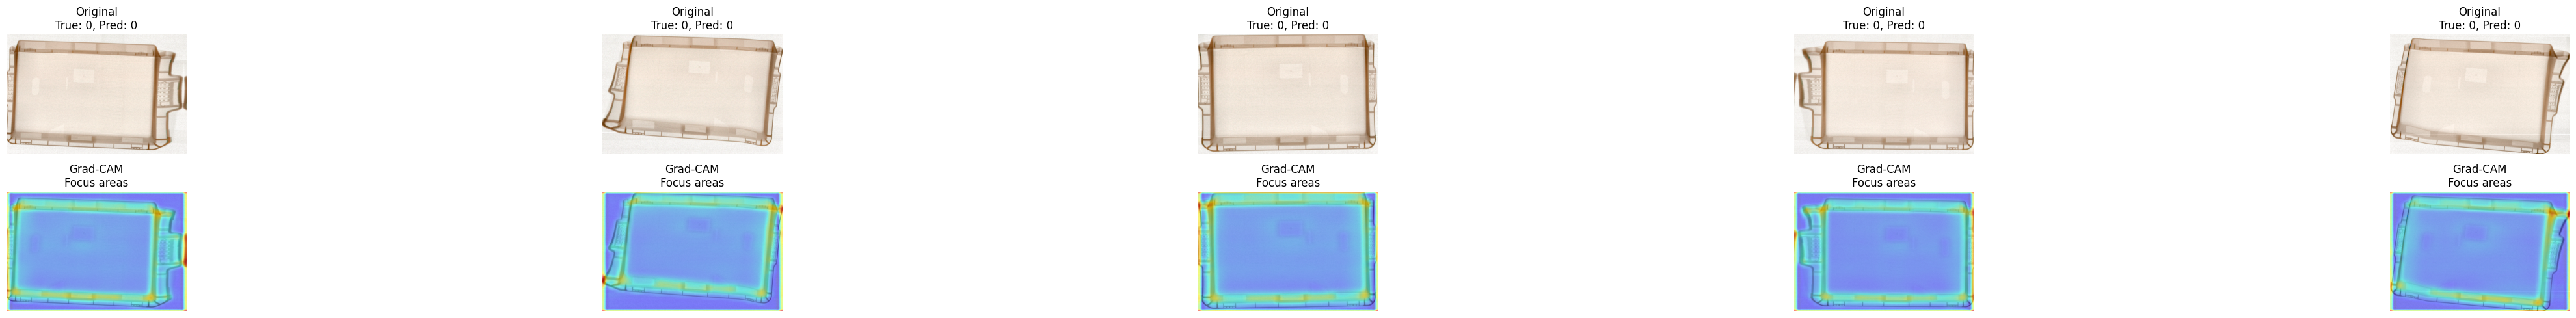

In [ ]:
# Grad-CAM for model explainability
import sys
sys.path.append('../..')
from src.xraygen.explain.gradcam import GradCAM

# Target the last conv layer
target_layer = model.features[6]  # Conv2d(32, 64, 3, padding=1)
gradcam = GradCAM(model, target_layer)

# Function to overlay heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.5):
    # img: PIL Image
    # heatmap: [H, W] numpy array in [0,1]
    import cv2
    img_np = np.array(img)
    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Visualize Grad-CAM for validation images
model.eval()
n = len(all_paths)
plt.figure(figsize=(10*n, 5))
for i in range(min(n, 5)):  # show up to 5
    path = all_paths[i]
    true_label = all_y[i]
    pred_label = all_pred[i]
    
    # Load original image
    img = Image.open(PROCESSED_ROOT / path).convert("RGB")
    
    # Prepare tensor for Grad-CAM
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Compute Grad-CAM
    heatmap = gradcam(img_tensor, target_class=pred_label)
    
    # Overlay
    overlay_img = overlay_heatmap(img, heatmap)
    
    # Plot
    plt.subplot(2, min(n, 5), i+1)
    plt.imshow(img)
    plt.title(f"Original\nTrue: {true_label}, Pred: {pred_label}")
    plt.axis("off")
    
    plt.subplot(2, min(n, 5), i+1 + min(n, 5))
    plt.imshow(overlay_img)
    plt.title(f"Grad-CAM\nFocus areas")
    plt.axis("off")

plt.tight_layout()
plt.show()

Visual Model Predictions

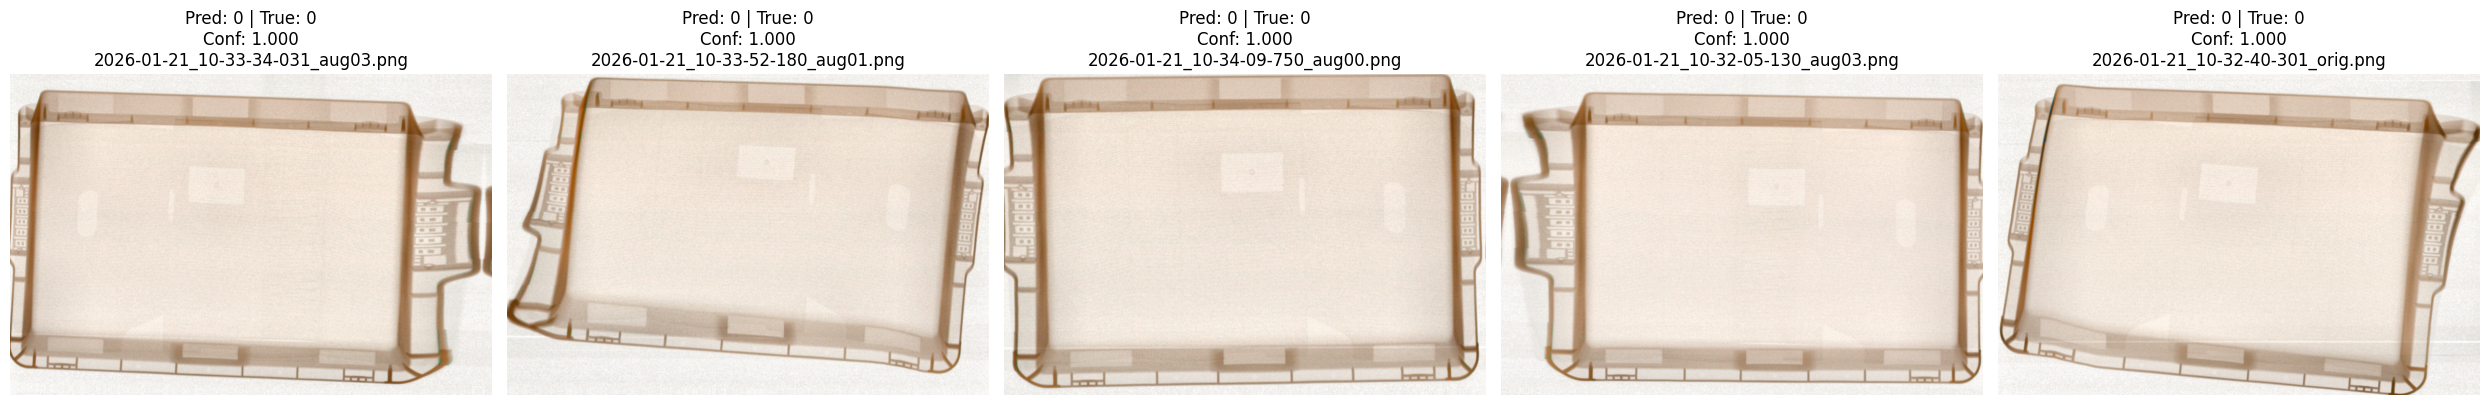

In [14]:
# Visualize predictions on validation set
import matplotlib.pyplot as plt
from PIL import Image

model.eval()
all_preds = []
all_labels = []
all_paths = []
all_confidences = []

with torch.no_grad():
    for imgs, labels, paths in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        confidences = probs.max(dim=1).values.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_paths.extend(paths)
        all_confidences.extend(confidences)

# Display images with predictions and confidence
n = len(all_paths)
plt.figure(figsize=(5*n, 5))
for i in range(n):
    img = Image.open(PROCESSED_ROOT / all_paths[i]).convert("RGB")
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {all_preds[i]} | True: {all_labels[i]}\nConf: {all_confidences[i]:.3f}\n{Path(all_paths[i]).name}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Use GradCam to evaluate